In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
SPLITS = {"train", "val", "test"}
SUB_DIRS = {"All_3D", "Mask_3D", "Mask_2D_Maximum"}

src = Path('/mnt/jbrockma/bachelor-thesis')

data_src = src / 'data/tissue'
npz_src = src / 'npz'
split_info_src = src / 'medmnist_data_split'

In [3]:
split_info_df = pd.read_csv(split_info_src / 'tissuemnist_split_info.csv', index_col='image_id')

In [4]:
im_fps_of_sub_dir = {sub_dir: {} for sub_dir in SUB_DIRS}  # it's like a cache for paths
for sub_dir in SUB_DIRS:
    im_fps_of_sub_dir[sub_dir] = {split: {} for split in SPLITS}
for child in data_src.rglob('*'):
    if child.is_file():
        try:
            split, idx = split_info_df.loc[child.stem]
        except KeyError:
            continue
        for sub_dir in SUB_DIRS:
            if sub_dir in child.parts:
                im_fps_of_sub_dir[sub_dir][split][idx] = child
                break

In [5]:
ours = np.load(npz_src / 'tissue-224.npz')
mnist_replica = np.load(npz_src / 'tissuemnist-replica.npz')
mnist = np.load(Path.home() / '.medmnist' / 'tissuemnist.npz')

sampled_ims_of_split = {}

for split in SPLITS:
    print(f'Starting split {split}')
    sampled_ims_of_split[split] = []
    
    images_key = f'{split}_images'
    print('Loading our dataset ...')
    our_ims = ours[images_key]
    print('Loading our TissueMNIST replica dataset ...')
    mnist_replica_ims = mnist_replica[images_key]
    print('Loading TissueMNIST dataset ...')
    mnist_ims = mnist[images_key]
    
    arange = min(len(our_ims), len(mnist_replica_ims), len(mnist_ims))
    
    rand_idcs = np.random.choice(arange, size=5, replace=False)
    
    for i in rand_idcs:
        our_im = Image.fromarray(our_ims[i])
        mnist_replica_im = Image.fromarray(mnist_replica_ims[i])
        mnist_im = Image.fromarray(mnist_ims[i])
        sampled_ims_of_split[split].append((i, (our_im, mnist_replica_im, mnist_im)))
    
    print(f'Split {split} done.')

Starting split val
Loading our dataset ...
Loading our TissueMNIST replica dataset ...
Loading TissueMNIST dataset ...
Split val done.
Starting split train
Loading our dataset ...
Loading our TissueMNIST replica dataset ...
Loading TissueMNIST dataset ...
Split train done.
Starting split test
Loading our dataset ...
Loading our TissueMNIST replica dataset ...
Loading TissueMNIST dataset ...
Split test done.


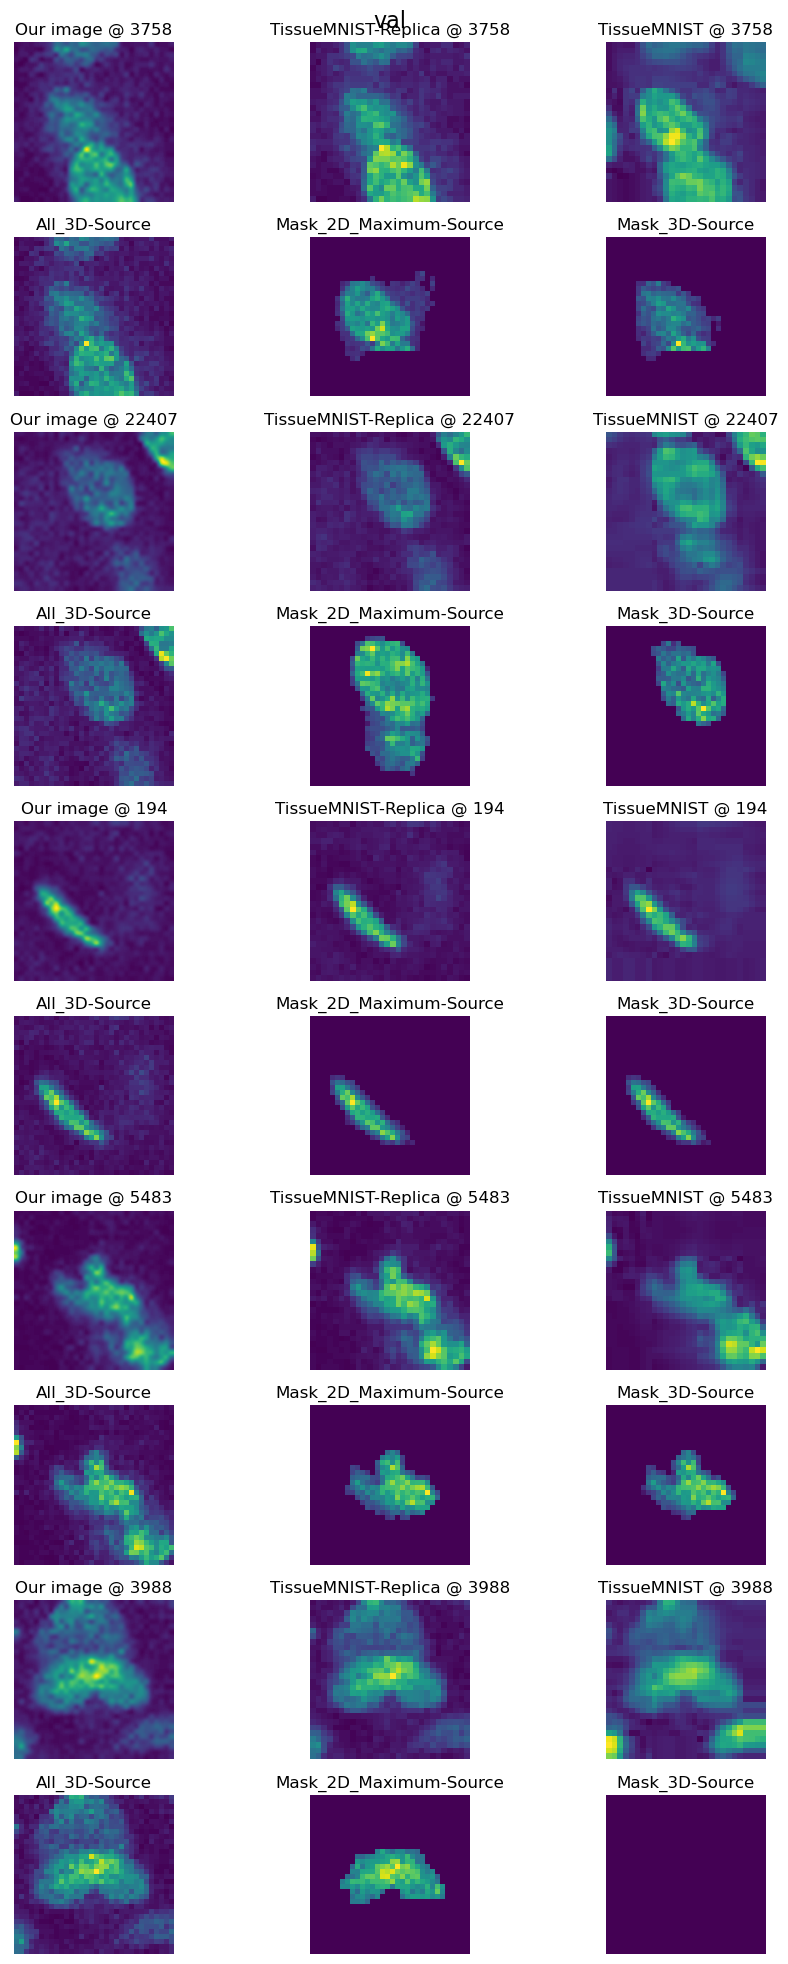

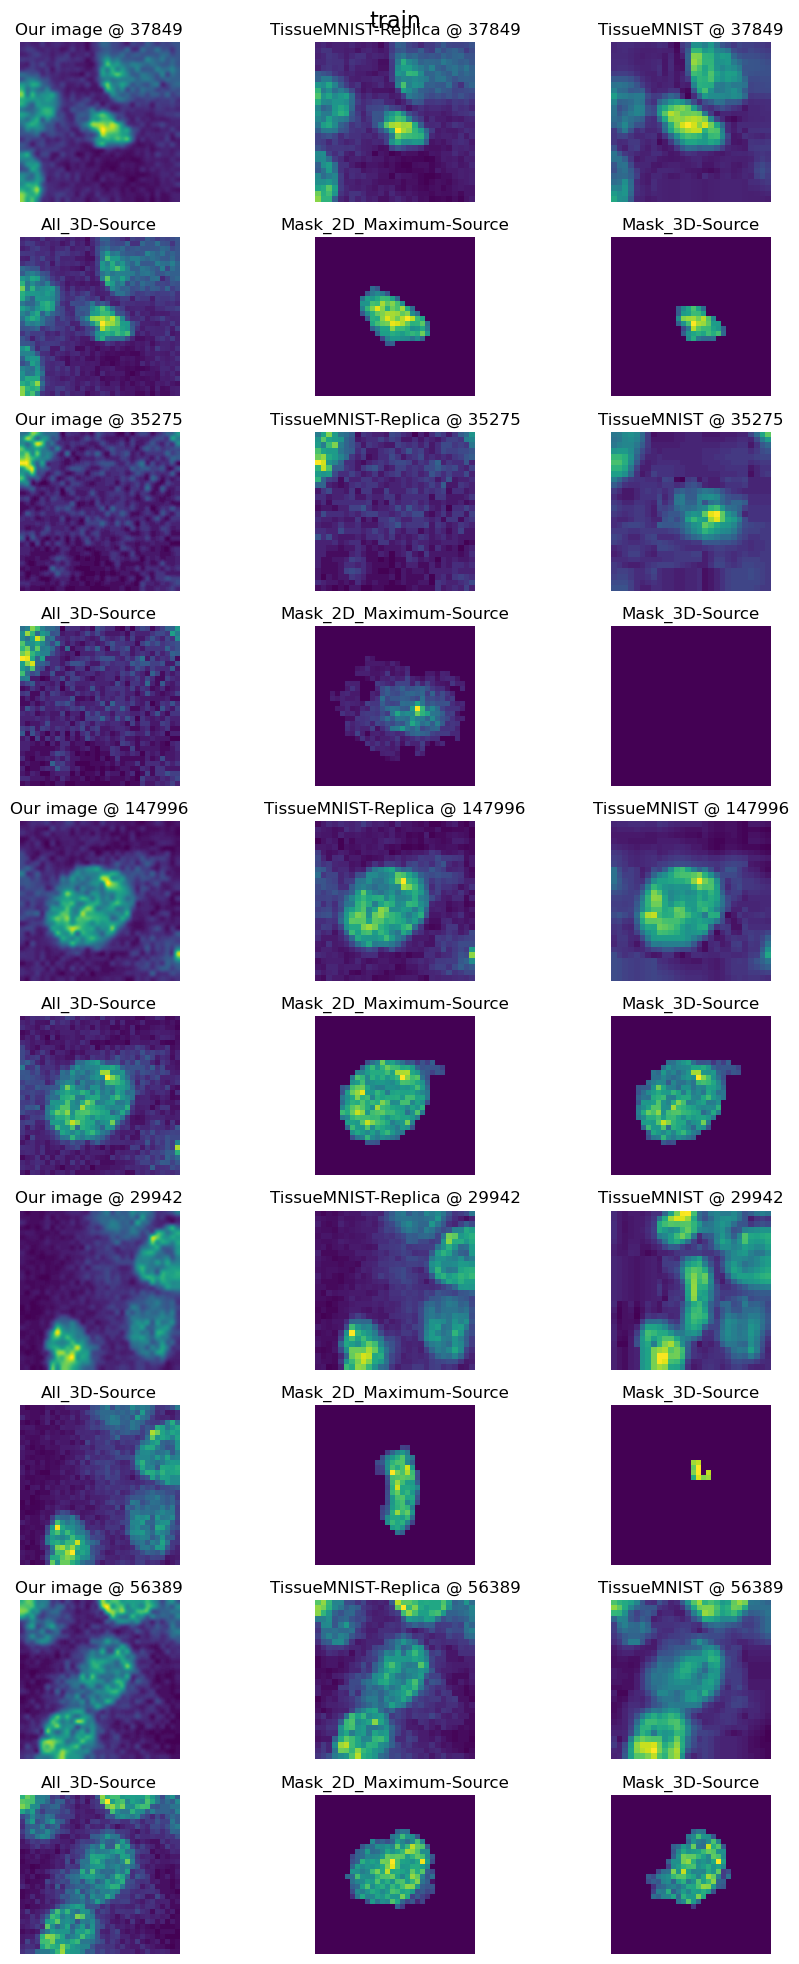

KeyError: 24717

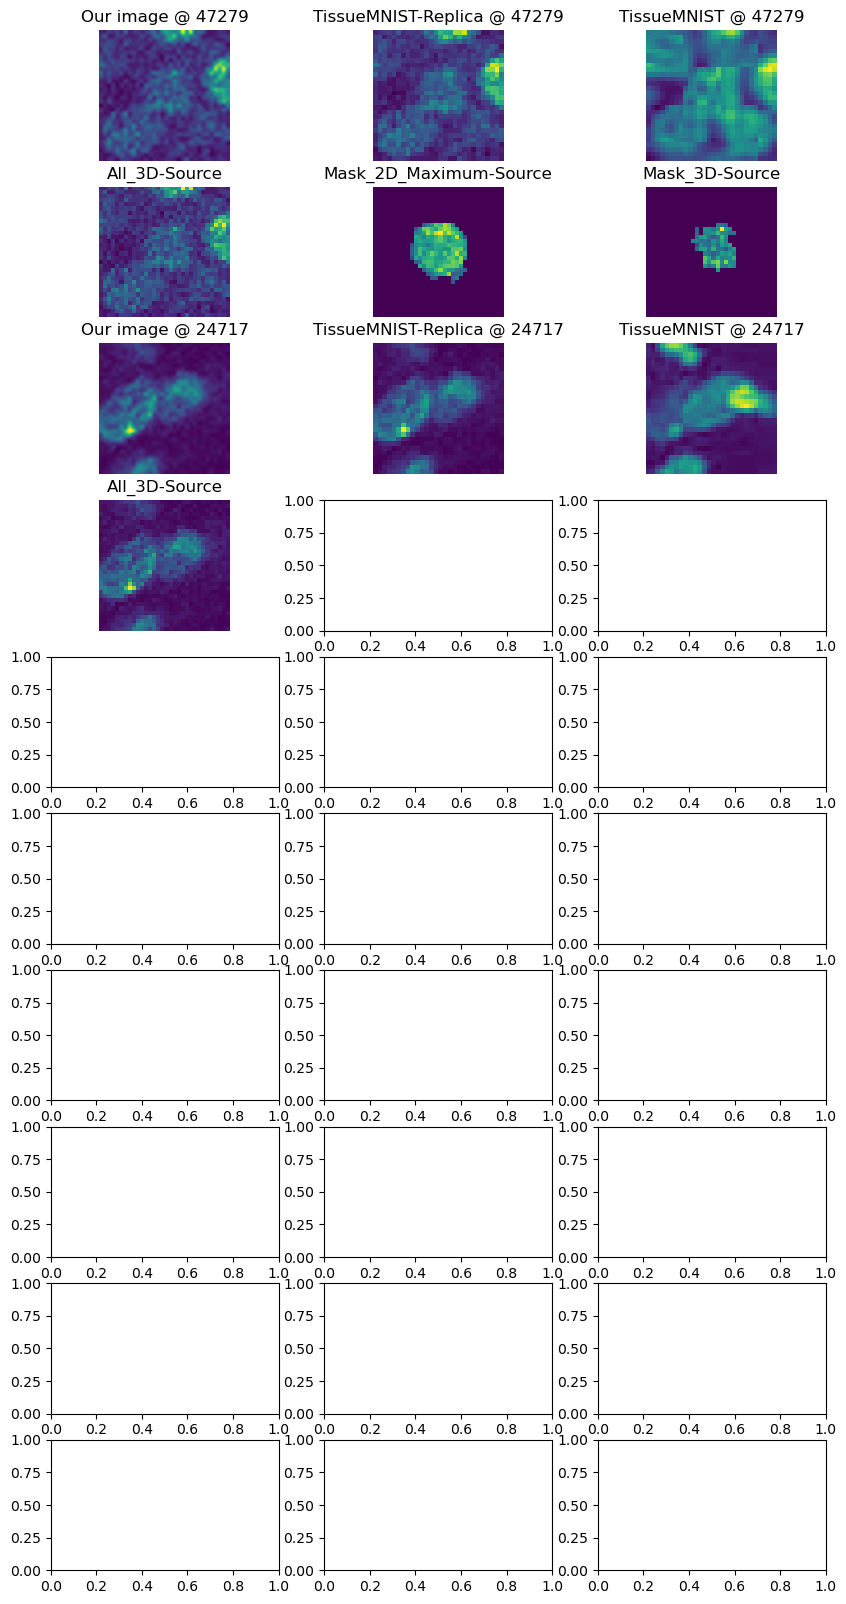

In [6]:
TITLE_PREFIXES = ['Our image', 'TissueMNIST-Replica', 'TissueMNIST']

for split in SPLITS:
    sampled_ims = sampled_ims_of_split[split]
    # Create a figure and axis for the grid layout
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 20))
    
    # Loop through each pair of images and display them side by side
    for i, (idx, im_triple) in enumerate(sampled_ims):
        row = i * 2
        for j, im in enumerate(im_triple):
            axes[row, j].imshow(im)
            axes[row, j].axis("off")
            axes[row, j].set_title(f'{TITLE_PREFIXES[j]} @ {idx}')
        
        row += 1
        
        for j, sub_dir in enumerate(SUB_DIRS):
            im_fps_of_split = im_fps_of_sub_dir[sub_dir]
            im_fps_at_idx = im_fps_of_split[split]
            im_fp = im_fps_at_idx[idx]
            with Image.open(im_fp) as im:
                im_array = np.asarray(im)
            axes[row, j].imshow(im_array)
            axes[row, j].axis('off')
            axes[row, j].set_title(f'{sub_dir}-Source')
    
    fig.suptitle(split, fontsize=16)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()